In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import subprocess
from platformdirs import user_cache_dir
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, generate_buyable_report, form_from_mgf_sirius, form_from_mgf_buddy, load_global_config

In [2]:
%cd /home/roger/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


# Global configs
Please modify the the configs in `configs/iceberg/iceberg_elucidation.yaml` accordingly; for `python_path` on molgpu, you can either
1) set up your own ms-gen environment from source
2) use Mrunali's pre-built environment, after telling conda to look in her folder with `conda config --add envs_dirs /home/mrunali/miniconda3/envs`
3) Clone Mrunali's pre-built environment into your own environment with `conda --clone` and then source that instead.

In [3]:
config = load_global_config()

# Elucidation on Pesticide Degradation

### Run SIRIUS to assign formula and adduct

In [5]:
inp_mgf = '/home/roger/ms_collaborators/Joules-Pesticide/sirius_no_int_std.mgf'
candidates_csv = '/home/roger/ms_collaborators/Joules-Pesticide/chemical_transformation_predictions.csv'

# load mgf and candidates
all_specs = common.parse_spectra_mgf(inp_mgf)
feat_id_to_specs = {
    entry[0]['FEATURE_ID']: entry[1][0][1]
    for entry in all_specs if entry[0]['MSLEVEL'] == '2'
}
feat_id_to_precursor = {
    entry[0]['FEATURE_ID']: float(entry[0]['PEPMASS'])
    for entry in all_specs if entry[0]['MSLEVEL'] == '2'
}
all_candidates = pd.read_csv(candidates_csv)

2252it [00:00, 25339.49it/s]


In [6]:
# Run SIRIUS to explain formula
profile = 'orbitrap'
ppm_max = 5
sirius_path = '/home/roger/miniforge3/condabin/conda run -n ms-main sirius'
top_k_preds = 2

# Run SIRIUS
feature_id_to_form = form_from_mgf_sirius(inp_mgf, top_k_preds, profile, ppm_max, sirius_path, elements_enforced='CHNOP', elements_considered='BrSClF')
# feature_id_to_form = form_from_mgf(inp_mgf, top_k_sirius_preds, profile, ppm_max, sirius_path, elements_enforced='CHNOPSClF', elements_considered='')

In [13]:
# Run buddy to explain formula
feature_id_to_form = form_from_mgf_buddy(inp_mgf, top_k_preds, profile, halogen=True)

msbuddy: molecular formula annotation for MS-based small molecule analysis.
563 queries loaded.
1 batch in total.
Batch 1/1:
Subformula assignment: 100%|██████████| 563/563 [00:09<00:00, 60.93it/s] 
Candidate formula ranking...
FDR calculation: 100%|██████████| 563/563 [00:00<00:00, 36216.02it/s]
Job finished.


In [168]:
form_csv = '/home/roger/ms_collaborators/Joules-Pesticide/simple_db_formula_matches.csv'

# Augment with formula db match
form_df = pd.read_csv(form_csv)
form_df['id'] = form_df['id'].astype(str)
for feature_id, forms in feature_id_to_form.items():
    sub_df = form_df[form_df['id'] == feature_id]
    if sub_df.shape[0] > 0:
        for _, row in sub_df.iterrows():
            if not any([row['mol_formula'] == f['form'] for f in forms]):
                new_rnk = max([f['rnk'] for f in forms]) + 1
                forms.append({'rnk': new_rnk, 'adduct': row['adduct'], 'form': row['mol_formula']})

3830 [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C22H14N2O3'}, {'rnk': 2, 'adduct': '[M+H]+', 'form': 'C20H12N5O2'}, {'rnk': 3, 'adduct': '[M+H]+', 'form': 'C19H15FN2O4'}]
1505 [{'rnk': 1, 'adduct': '[M+Na]+', 'form': 'C5H12NO3PS2'}, {'rnk': 2, 'adduct': '[M+H]+', 'form': 'C4H12O6PS2'}]
716 [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C3H4ClN5'}, {'rnk': 2, 'adduct': '[M+Na]+', 'form': 'C3H8ClN2O'}]
417 [{'rnk': 1, 'adduct': '[M+Na]+', 'form': 'C4H11O4P'}, {'rnk': 2, 'adduct': '[M+Na]+', 'form': 'C5H11ClO3'}]
576 [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C5H9N5O'}, {'rnk': 2, 'adduct': '[M+Na]+', 'form': 'C5H13N2O2'}]
1508 [{'rnk': 1, 'adduct': '[M+Na]+', 'form': 'C8H14O5'}, {'rnk': 2, 'adduct': '[M+Na]+', 'form': 'C7H8N7'}]
3351 [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C4H8N5OP'}, {'rnk': 2, 'adduct': '[M+H]+', 'form': 'C8H5N4O'}, {'rnk': 3, 'adduct': '[M+H]+', 'form': 'C5H8ClN5'}]
6842 [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C6H10O5'}, {'rnk': 2, 'adduct': '[M+H]+', 'form': 'C5H4N7'}]
503 [

In [15]:
feature_list_csv = '/home/roger/ms_collaborators/Joules-Pesticide/ids_sorted_by_area.csv'
feature_list_df = pd.read_csv(feature_list_csv)
feature_list_df = feature_list_df[~feature_list_df['sample_groups'].isin(['set()'])]  # remove entries that does not appear in 3 replicates
all_dicts = {k: [] for k in feature_list_df.columns}
for i in range(1, 6):
    all_dicts[f'top{i} adduct'] = []
    all_dicts[f'top{i} form'] = []

for i, row in tqdm(feature_list_df.iterrows()):
    feat_id = str(row['id'])
    if not feat_id in feature_id_to_form:
        continue
    for k in feature_list_df.columns:
        all_dicts[k].append(row[k])
    forms = feature_id_to_form[feat_id]
    for i in range(5):
        if len(forms) >= i+1:
            form_dic = forms[i]
            assert form_dic["rnk"] == i+1
            all_dicts[f'top{i+1} adduct'].append(form_dic['adduct'])
            all_dicts[f'top{i+1} form'].append(form_dic['form'])
        else:
            all_dicts[f'top{i+1} adduct'].append(None)
            all_dicts[f'top{i+1} form'].append(None)
form_df = pd.DataFrame.from_dict(all_dicts)

547it [00:00, 44378.59it/s]


In [10]:
import pickle

# prepare entries. The following is time-consuming please switch to run_scripts/dag_model/generate_buyable_report_pesticide.py
feature_id_path = 'data/retrieval/pubchem/pesticide_feat_id_to_dict.p'
if Path(feature_id_path).exists():
    with open(feature_id_path, 'rb') as f:
        feat_id_to_dict = pickle.load(f)
else:
    feat_id_to_dict = {}
    for feature_id, all_info in tqdm(feature_id_to_form.items()):
        all_info = sorted(all_info, key=lambda x: x['rnk'])
        adduct_to_smiles = {}
        for info in all_info:
            if info['adduct'] not in adduct_to_smiles:
                adduct_to_smiles[info['adduct']] = []
            adduct_to_smiles[info['adduct']] += candidates_from_pubchem(info['form'])

            # get other candidates from EPA enumeration result
            for cand_form, cand_smi in zip(all_candidates['formula'], all_candidates['smiles']):
                diff = common.formula_difference(info['form'], cand_form)
                if len(diff) == 0:  # same formula
                    if info['adduct'] in adduct_to_smiles:
                        adduct_to_smiles[info['adduct']].append(cand_smi)

        if len(adduct_to_smiles) > 0:
            # remove duplicate inchikey
            for adduct, smiles in adduct_to_smiles.items():
                inchikeys = [common.inchikey_from_smiles(smi) for smi in smiles]
                _, uniq_idx = np.unique(inchikeys, return_index=True)
                adduct_to_smiles[adduct] = np.array(smiles)[uniq_idx].tolist()

            feat_id_to_dict[feature_id] = {
                'feature_id': feature_id,
                'spec': {'nan': feat_id_to_specs[feature_id]},
                'adduct_to_smiles': adduct_to_smiles,
            }

    # with open(feature_id_path, 'wb') as f:
    #     pickle.dump(feat_id_to_dict, f)

100%|██████████| 549/549 [00:01<00:00, 292.78it/s]


In [14]:
# write feature matchings for analysis
row_to_match = {}
for i in feat_id_to_dict.values():
    for adduct, smis in i['adduct_to_smiles'].items():
        for smi in smis:
            for row_idx in all_candidates.index[all_candidates['smiles'] == smi]:
                if row_idx not in row_to_match:
                    row_to_match[row_idx] = f"feat_id={i['feature_id']}, {adduct}"
                else:
                    row_to_match[row_idx] += f"; feat_id={i['feature_id']}, {adduct}"
all_candidates['matched features'] = row_to_match
# all_candidates.to_csv(candidates_csv + '2', index=False)
all_candidates

,genKey,routes,smiles,iupac,formula,mass,exactMass,production,accumulation,globalAccumulation,likelihood,matched features
0,molecule 1,NaN,CCNC1=NC(NC(C)C)=NC(Cl)=N1,"6-chloro-N2-ethyl-N4-(propan-2-yl)-1,3,5-triaz...",C8H14ClN5,215.690,215.093773,100.00,0.00,0.00,UNLIKELY,NaN
1,molecule 1.1,Aromatic Halide Photohydrolysis,CCNC1=NC(=O)NC(NC(C)C)=N1,"4-(ethylamino)-6-[(propan-2-yl)amino]-1,2-dihy...",C8H15N5O,197.242,197.127660,23.33,0.00,0.00,UNLIKELY,"feat_id=1064, [M+H]+"
2,molecule 1.1.1,s-Triazine Side Chain N-alkyl Photooxidation t...,CC(C)NC1=NC(=O)NC(NC(C)=O)=N1,"N-{6-oxo-4-[(propan-2-yl)amino]-1,6-dihydro-1,...",C8H13N5O2,211.225,211.106925,7.42,0.00,0.00,UNLIKELY,"feat_id=755, [M+H]+"
3,molecule 1.1.2,s-Triazine Side Chain Photochemical N-dealkyla...,CC(C)NC1=NC(N)=NC(=O)N1,"4-amino-6-[(propan-2-yl)amino]-1,2-dihydro-1,3...",C6H11N5O,169.188,169.096360,7.42,0.00,0.00,UNLIKELY,"feat_id=420, [M+H]+"
4,molecule 1.1.3,s-Triazine Side Chain Photochemical N-dealkyla...,CCNC1=NC(N)=NC(=O)N1,"4-amino-6-(ethylamino)-1,2-dihydro-1,3,5-triaz...",C5H9N5O,155.161,155.080710,7.42,0.00,0.00,UNLIKELY,"feat_id=295, [M+H]+; feat_id=576, [M+H]+"
...,...,...,...,...,...,...,...,...,...,...,...,...
343,molecule 12.11.7,Organophosphorus Ester Hydrolysis 1,CCOC(=O)CC(SP(O)(=S)OC)C(O)=O,4-ethoxy-2-{[hydroxy(methoxy)sulfanylidene-lam...,C7H13O6PS2,288.270,287.989118,0.20,0.14,0.00,UNLIKELY,"feat_id=1165, [M+Na]+"
344,molecule 12.11.8,Organophosphorus Ester Hydrolysis 1,CO,methanol,CH4O,32.042,32.026215,0.20,0.20,24.14,LIKELY,NaN
345,molecule 12.11.9,Carboxylic Acid Ester Hydrolysis,COP(=S)(OC)SC(CC(O)=O)C(O)=O,2-{[dimethoxy(sulfanylidene)-lambda5-phosphany...,C6H11O6PS2,274.240,273.973467,0.03,0.00,0.00,UNLIKELY,NaN
346,molecule 12.11.10,Carboxylic Acid Ester Hydrolysis,CCO,ethanol,C2H6O,46.069,46.041865,0.03,0.03,16.72,LIKELY,NaN


In [20]:
# How many enumeration candidates are in pubchem
import pubchempy as pcp

def is_in_pubchem(smiles):
    inchikey = common.inchikey_from_smiles(common.rm_stereo(smiles))
    compounds = pcp.get_compounds(smiles, namespace='smiles')
    for cmpd in compounds:
        if hasattr(cmpd, 'cid') and cmpd.cid is not None:
            cand_smis = candidates_from_pubchem(common.form_from_smi(smiles))
            cand_inchikeys = [common.inchikey_from_smiles(common.rm_stereo(smi)) for smi in cand_smis]
            if not inchikey in cand_inchikeys:
                print(f'Found a non-live entry: CID={cmpd.cid}')
            return 1
    return 0

all_smiles = [row['smiles'] for idx, row in all_candidates.iterrows()]
all_smiles = np.unique(all_smiles)
in_pubchem = [is_in_pubchem(smi) for smi in tqdm(all_smiles)]
sum(in_pubchem)

  2%|▏         | 3/175 [00:16<13:22,  4.67s/it]

Found a non-live entry: CID=137202720


  6%|▌         | 10/175 [00:26<07:38,  2.78s/it]

Found a non-live entry: CID=86230378


 31%|███       | 54/175 [02:19<06:25,  3.19s/it]

Found a non-live entry: CID=85546563


 45%|████▌     | 79/175 [03:07<03:52,  2.42s/it]

Found a non-live entry: CID=85640901


 53%|█████▎    | 93/175 [03:35<02:56,  2.16s/it]

Found a non-live entry: CID=14604950


100%|██████████| 175/175 [06:54<00:00,  2.37s/it]


101

### Run ICEBERG prediction

In [20]:
def pesticide_elucidation(info_dict, vis_peaks=False, energy=[30, 40, 60]):
    pesticide_config = copy.deepcopy(config)
    pesticide_config['nce'] = True # use nce for collision energy
    pesticide_config['step_collision_energy'] = True  # step collision energy i.e. multiple spectrum are obtained then merged
    pesticide_config['real_spec_type'] = 'raw'

    all_results = []

    for adduct, smiles in info_dict['adduct_to_smiles'].items():
        pesticide_config['adduct'] = adduct

        # Run ICEBERG to predict spectra
        result_path, pmz = iceberg_prediction(smiles, energy, **pesticide_config)

        # Compare spectrum similarity for elucidation
        topk_results = elucidation_over_candidates(result_path, info_dict["spec"], precursor_mass=pmz, mol_name=info_dict["feature_id"], topk=10, **pesticide_config)
        all_results += [list(res) + [result_path, pmz] for res in topk_results]

    # Plot top results
    all_results = sorted(all_results, key=lambda x: x[1])[:10]
    img = plot_top_mols([res[:3] for res in all_results])

    # Visualize and explain peaks
    if vis_peaks:
        for smi, _, __, result_path, pmz in all_results:
            explain_peaks(result_path, info_dict["spec"], pmz, smi, num_peaks=10, **pesticide_config)

    return img, all_results[0][1]

In [13]:
feat_id_to_dict.keys()

dict_keys(['1285'])

In [14]:
fid = '1285'
print(feat_id_to_dict[fid]['adduct_to_smiles'].keys())
np.unique([common.form_from_smi(i) for v in feat_id_to_dict[fid]['adduct_to_smiles'].values() for i in v])

dict_keys(['[M+H]+'])


array(['C4H11NO3P', 'C8H8O3'], dtype='<U9')

In [1]:
pesticide_elucidation(feat_id_to_dict['1285'], True)[0]

NameError: name 'pesticide_elucidation' is not defined

## Generate Buyable Report

In [37]:
energy = [30, 40, 60]
pesticide_config = copy.deepcopy(config)
pesticide_config['nce'] = True # use nce for collision energy
pesticide_config['step_collision_energy'] = True # step collision energy i.e. multiple spectrum are obtained then merged
pesticide_config['real_spec_type'] = 'raw'

# only plot features with entropy distance < 0.6
interested_dicts = []
for feat_id, info in feat_id_to_dict.items():
    img, best_dist = pesticide_elucidation(info, False)
    if best_dist < 0.6:
        interested_dicts.append((best_dist, feat_id, info))
interested_dicts = sorted(interested_dicts)

feat_ids, exp_specs, adduct_to_smiles = [], [], []
for best_dist, feat_id, info in interested_dicts:
    feat_ids.append(feat_id)
    exp_specs.append(info['spec'])
    adduct_to_smiles.append(info['adduct_to_smiles'])

generate_buyable_report(feat_ids, exp_specs, adduct_to_smiles, pesticide_config, energy, output_name='pesticide_buyable_report')

CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/8701ce71111ff4d5f77c21c7690b2756/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/8701ce71111ff4d5f77c21c7690b2756 \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:50:00,981 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/8701ce71111ff4d5f77c21c7690b2756/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/8701ce71111ff4d5f77c21c7690b2756
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:50:02,935 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:50:

  0%|          | 0/14 [00:00<?, ?it/s]

2024-09-13 17:50:07,258 INFO: There are 111 entries to process


100%|██████████| 14/14 [00:05<00:00,  2.50it/s]


2024-09-13 17:50:12,859 INFO: Program finished in: 11.88442873954773 seconds
CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/00b5bf80ebe48effd746175a9bd4e170/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/00b5bf80ebe48effd746175a9bd4e170 \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:50:16,631 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/00b5bf80ebe48effd746175a9bd4e170/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/00b5bf80ebe48effd746175a9bd4e170
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:50:17,404 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:50:

  0%|          | 0/2 [00:00<?, ?it/s]

2024-09-13 17:50:22,086 INFO: There are 9 entries to process


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


2024-09-13 17:50:23,945 INFO: Program finished in: 7.319716453552246 seconds
CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/faee0e2d072e979ba5651707947d9efd/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/faee0e2d072e979ba5651707947d9efd \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:50:30,235 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/faee0e2d072e979ba5651707947d9efd/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/faee0e2d072e979ba5651707947d9efd
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:50:30,974 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:50:

  0%|          | 0/431 [00:00<?, ?it/s]

2024-09-13 17:50:36,926 INFO: There are 3447 entries to process


100%|██████████| 431/431 [01:42<00:00,  4.20it/s]


2024-09-13 17:52:19,626 INFO: Program finished in: 109.39596557617188 seconds
CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/094732e7126e09cedbeb68e32ad91f07/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/094732e7126e09cedbeb68e32ad91f07 \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:52:26,812 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/094732e7126e09cedbeb68e32ad91f07/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/094732e7126e09cedbeb68e32ad91f07
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:52:27,568 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:52:

  0%|          | 0/15 [00:00<?, ?it/s]

2024-09-13 17:52:32,505 INFO: There are 120 entries to process


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


2024-09-13 17:52:36,673 INFO: Program finished in: 9.866114616394043 seconds
CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/df9a724849a77b284d1dd4de630b2f1c/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/df9a724849a77b284d1dd4de630b2f1c \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:52:42,473 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/df9a724849a77b284d1dd4de630b2f1c/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/df9a724849a77b284d1dd4de630b2f1c
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:52:43,221 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:52:

  0%|          | 0/188 [00:00<?, ?it/s]

2024-09-13 17:52:48,230 INFO: There are 1503 entries to process


100%|██████████| 188/188 [00:25<00:00,  7.43it/s]


2024-09-13 17:53:13,563 INFO: Program finished in: 31.09615445137024 seconds
CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/4a2a4e47f1c69a862807e480b8acff29/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/4a2a4e47f1c69a862807e480b8acff29 \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:53:18,673 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/4a2a4e47f1c69a862807e480b8acff29/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/4a2a4e47f1c69a862807e480b8acff29
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:53:19,435 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:53:

  0%|          | 0/7 [00:00<?, ?it/s]

2024-09-13 17:53:24,399 INFO: There are 54 entries to process


 29%|██▊       | 2/7 [00:02<00:05,  1.17s/it]
multiprocess.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred/src/ms_pred/common/parallel_utils.py", line 76, in batch_func
    outputs.append(function(i))
  File "/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred/src/ms_pred/dag_pred/predict_smis.py", line 200, in producer_func
    full_outputs = model.predict_mol(
  File "/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred/src/ms_pred/dag_pred/joint_model.py", line 102, in predict_mol
    frag_tree = self.gen_model_obj.predict_mol(
  File "/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred/src/ms_pred/dag_pred/g

CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/52d396b5b3c864e0a6780b747b60e36b/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/52d396b5b3c864e0a6780b747b60e36b \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:53:33,067 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/52d396b5b3c864e0a6780b747b60e36b/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/52d396b5b3c864e0a6780b747b60e36b
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:53:33,303 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:53:

100%|██████████| 987/987 [00:05<00:00, 171.63it/s]


2024-09-13 17:53:39,229 INFO: There are 2961 entries to process


100%|██████████| 371/371 [01:10<00:00,  5.24it/s]


2024-09-13 17:54:50,092 INFO: Program finished in: 77.03100967407227 seconds
CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/c48a08e62389d785272c62b1ff5b9c6f/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/c48a08e62389d785272c62b1ff5b9c6f \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:54:58,782 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/c48a08e62389d785272c62b1ff5b9c6f/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/c48a08e62389d785272c62b1ff5b9c6f
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:54:59,569 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:54:

  0%|          | 0/276 [00:00<?, ?it/s]

2024-09-13 17:55:04,947 INFO: There are 2208 entries to process


100%|██████████| 276/276 [01:08<00:00,  4.00it/s]


2024-09-13 17:56:13,927 INFO: Program finished in: 75.14925050735474 seconds
CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/86e8bcbad1ef0fed41babf01fba94c42/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/86e8bcbad1ef0fed41babf01fba94c42 \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:56:21,270 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/86e8bcbad1ef0fed41babf01fba94c42/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/86e8bcbad1ef0fed41babf01fba94c42
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:56:22,010 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:56:

  0%|          | 0/24 [00:00<?, ?it/s]

2024-09-13 17:56:25,041 INFO: There are 186 entries to process


100%|██████████| 24/24 [00:06<00:00,  3.76it/s]


2024-09-13 17:56:31,437 INFO: Program finished in: 10.172414064407349 seconds
CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/ba2569a97002a0337ad57fc7b1c4deb5/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/ba2569a97002a0337ad57fc7b1c4deb5 \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:56:37,223 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/ba2569a97002a0337ad57fc7b1c4deb5/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/ba2569a97002a0337ad57fc7b1c4deb5
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:56:37,997 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:56:

  0%|          | 0/123 [00:00<?, ?it/s]

2024-09-13 17:56:43,117 INFO: There are 981 entries to process


100%|██████████| 123/123 [00:18<00:00,  6.75it/s]


2024-09-13 17:57:01,370 INFO: Program finished in: 24.153339862823486 seconds
CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/813fb3835405bf15861afce1b36b0410/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/813fb3835405bf15861afce1b36b0410 \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-09-13 17:57:24,169 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/813fb3835405bf15861afce1b36b0410/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/813fb3835405bf15861afce1b36b0410
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-09-13 17:57:26,106 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-09-13 17:57:

100%|██████████| 1016/1016 [00:10<00:00, 94.28it/s] 


2024-09-13 17:57:38,216 INFO: There are 97449 entries to process


 35%|███▍      | 355/1016 [14:32<25:32,  2.32s/it]  Process SpawnPoolWorker-5:
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-4:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-1:
Process SpawnPoolWorker-3:
 35%|███▍      | 355/1016 [14:34<27:09,  2.46s/it]
Traceback (most recent call last):
  File "/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/multiprocess/pool.py", line 853, in next
    item = self._items.popleft()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred/src/ms_pred/dag_pred/predict_smis.py", line 266, in <module>
    predict()
  File "/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred/src/ms_pred/dag_pred/predict_smis.py", line 258, in predict
    common.chunked_parallel(all_batched_entries, producer_func, output_func=write_h5_func,
  File "/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred/src/ms_pre

KeyboardInterrupt: 

# Make plots on FEATURE_ID=919

In [4]:
from ms_pred.common.plot_utils import set_style

set_style()

kinetics_df = pd.read_csv('data/exp_specs/pesticide/peak_area_table_919_sample_info.csv')

days = kinetics_df['Time (days)'].unique()
days.sort()

In [5]:
t0_df = kinetics_df[kinetics_df['Time (days)'] == 0]
t0_mean, t0_std = np.mean(t0_df['Normalized Peak Area']), np.std(t0_df['Normalized Peak Area'])

In [6]:
light_data = [[t0_mean], [t0_std]]
dark_data = [[t0_mean], [t0_std]]
for day in days[1:]:
    tmp_df = kinetics_df[kinetics_df['Time (days)'] == day]
    light_df = tmp_df[tmp_df['Conditions'] == 'Light']
    light_np = light_df['Normalized Peak Area'].to_numpy()
    if len(light_np) < 3:
        light_np = np.concatenate((light_np, np.zeros(3 - len(light_np))))
    light_data[0].append(np.mean(light_np))
    light_data[1].append(np.std(light_np))

    dark_df = tmp_df[tmp_df['Conditions'] == 'Dark']
    dark_np = dark_df['Normalized Peak Area'].to_numpy()
    dark_np = np.concatenate((dark_np, np.zeros(3 - len(dark_np))))
    dark_data[0].append(np.mean(dark_np))
    dark_data[1].append(np.std(dark_np))
light_data = np.array(light_data)
dark_data = np.array(dark_data)

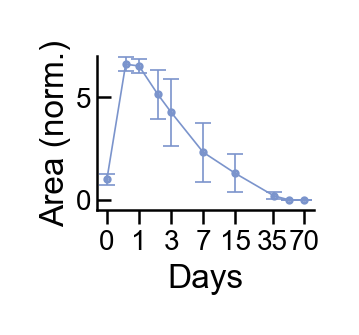

In [8]:
plt.figure(figsize=(.7, 0.5), dpi=400)
_, caps, _ = plt.errorbar(
    days + 1, light_data[0] / t0_mean, yerr=light_data[1] / t0_mean, 
    fmt='-o', markersize=0.5, capsize=1.5, color='#7B94CC', linewidth=0.3
)
for cap in caps:
    cap.set_markeredgewidth(0.3)

# set axis ticks and labels
ax = plt.gca()
ax.set_xscale('log')
ax.xaxis.set_ticks(np.array([0, 1, 3, 7, 15, 35, 70]) +1)
ax.set_xticklabels([0, 1, 3, 7, 15, 35, 70])
ax.xaxis.set_ticks([], minor=True)
plt.ylabel('Area (norm.)')
ax.yaxis.set_label_coords(-0.12, 0.5)
plt.xlabel("Days")
ax.xaxis.set_label_coords(0.5, -0.35)
ax.set_ylim(-0.5, 7)

# remove box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("results/figs_iceberg/919_light_kinetics.pdf", bbox_inches="tight", transparent=True)

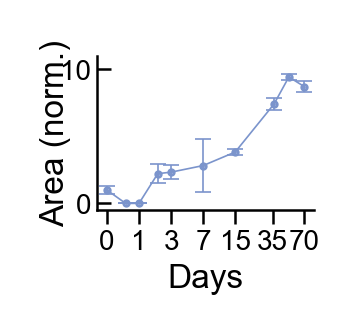

In [9]:
plt.figure(figsize=(.7, 0.5), dpi=400)
_, caps, _ = plt.errorbar(
    days + 1, dark_data[0] / t0_mean, yerr=dark_data[1] / t0_mean,
    fmt='-o', markersize=0.5, capsize=1.5, color='#7B94CC', linewidth=0.3
)

for cap in caps:
    cap.set_markeredgewidth(0.3)

# set axis ticks and labels
ax = plt.gca()
ax.set_xscale('log')
ax.xaxis.set_ticks(np.array([0, 1, 3, 7, 15, 35, 70]) +1)
ax.set_xticklabels([0, 1, 3, 7, 15, 35, 70])
ax.xaxis.set_ticks([], minor=True)
plt.ylabel('Area (norm.)')
ax.yaxis.set_label_coords(-0.12, 0.5)
plt.xlabel("Days")
ax.xaxis.set_label_coords(0.5, -0.35)
ax.set_ylim(-0.5, 11)

# remove box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("results/figs_iceberg/919_dark_kinetics.pdf", bbox_inches="tight", transparent=True)